In [1]:
%matplotlib inline


Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.

For example, look at this network that classifies digit images:

.. figure:: /_static/img/mnist.png
   :alt: convnet

   convnet

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

Let’s define this network:



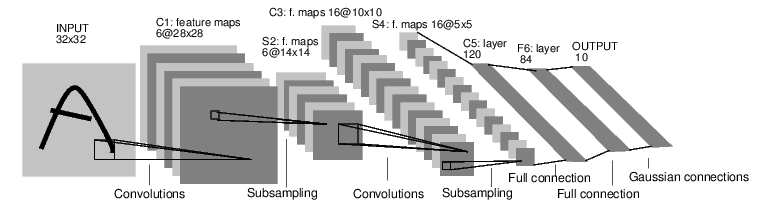

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        # nn.Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [3]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


Let try a random 32x32 input
Note: Expected input size to this net(LeNet) is 32x32. To use this net on
MNIST dataset, please resize the images from the dataset to 32x32.



In [4]:
input = torch.randn(1, 1, 32, 32)
print(input[0][0][0])
print(input[0][0][0].size())
print(input[0][0][1])
print(input[0][0][1].size())
print(input[0][0][2])
print(input[0][0][2].size())
out = net(input)
print(out)

tensor([ 0.6890,  0.5559, -0.6991,  1.8841, -0.6990, -0.2630,  1.2487,  0.4568,
        -0.8445,  0.5268, -0.9946,  1.7062,  1.3454,  1.7773,  1.0024, -0.6479,
        -0.9825,  0.9440,  0.3180,  0.4676, -0.7714,  0.7614,  0.7304, -1.2629,
        -2.0033, -0.5250, -0.7723, -0.8947, -1.7870,  0.6293,  2.5178, -0.6775])
torch.Size([32])
tensor([ 0.2904,  0.2479, -1.3248,  0.4362,  0.7447,  0.0843, -0.1314,  0.3116,
        -0.0592,  0.3214,  0.8761, -1.5697,  0.0535, -0.3872, -0.2832,  0.4931,
        -0.3878, -0.9577, -0.0157, -1.5522,  1.5528,  0.1988,  0.1297,  1.3570,
         0.7378, -0.9239,  0.4312, -0.9311, -0.4171, -0.5968, -1.3136,  0.1425])
torch.Size([32])
tensor([-0.3400,  0.0507,  1.3064,  0.3313, -1.1454,  1.0108, -0.7957,  0.9708,
         0.5384,  1.0422, -0.0034, -2.3662,  0.0429, -1.0320, -0.8295,  1.5448,
         0.8570, -0.1524,  0.6636, -1.4784,  0.3319, -1.7374, -0.1557, -0.2582,
        -0.4667, -1.4626, -0.6241, -0.4353,  1.1098, -0.3142,  1.0183,  0.3376])
tor

Zero the gradient buffers of all parameters and backprops with random
gradients:



In [5]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.</p></div>

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation, creates at
     least a single ``Function`` node, that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <http://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:



In [6]:
output = net(input)
print(output.size())
print(output)
target = torch.randn(10)  # a dummy target, for example
print(target.size())
print(target)
target = target.view(1, -1)  # make it the same shape as output
print(target.size())
print(target)
criterion = nn.MSELoss() # computes the mean-squared error between the input and the target

loss = criterion(output, target)
print(loss)

torch.Size([1, 10])
tensor([[-0.0414,  0.0265,  0.1172,  0.0082,  0.1461, -0.1290,  0.0678, -0.0643,
         -0.0039,  0.0052]], grad_fn=<ThAddmmBackward>)
torch.Size([10])
tensor([-0.0610,  0.0882, -0.1347, -0.7549, -0.4179,  1.2769,  0.5564, -5.3269,
        -0.5274, -1.8425])
torch.Size([1, 10])
tensor([[-0.0610,  0.0882, -0.1347, -0.7549, -0.4179,  1.2769,  0.5564, -5.3269,
         -0.5274, -1.8425]])
tensor(3.4567, grad_fn=<MseLossBackward>)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requires_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [7]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [8]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0037,  0.0143,  0.0002,  0.0061, -0.0048, -0.0134])


Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is `here <http://pytorch.org/docs/nn>`_.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [9]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

.. Note::

      Observe how gradient buffers had to be manually set to zero using
      ``optimizer.zero_grad()``. This is because gradients are accumulated
      as explained in `Backprop`_ section.

